In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('Data.csv')
print(df.head())

   Segment ID    PCI  Road Type  AADT Asphalt Type  Last Maintenance  \
0  SID 155440  70.00  Secondary  4634     Concrete              2022   
1  SID 244365  37.87   Tertiary  3474      Asphalt              2017   
2  SID 137867  88.32   Tertiary  1734     Concrete              2019   
3  SID 540519  52.30   Tertiary  3119      Asphalt              2008   
4  SID 745776  49.10   Tertiary  3505      Asphalt              2019   

   Average Rainfall  Rutting   IRI  Needs Maintenance  
0             42.07    15.11  0.68                  0  
1             79.60    19.67  0.99                  1  
2             62.69    14.73  0.50                  0  
3             79.32    17.01  1.04                  1  
4             71.81    21.08  1.18                  1  


In [3]:
print("Rozmiar danych:", df.shape)
print("Kolumny:", df.columns.values)
print("Braki w kolumnach:\n", df.isnull().sum())

Rozmiar danych: (1050000, 10)
Kolumny: ['Segment ID' 'PCI' 'Road Type' 'AADT' 'Asphalt Type' 'Last Maintenance'
 'Average Rainfall' 'Rutting' 'IRI' 'Needs Maintenance']
Braki w kolumnach:
 Segment ID           0
PCI                  0
Road Type            0
AADT                 0
Asphalt Type         0
Last Maintenance     0
Average Rainfall     0
Rutting              0
IRI                  0
Needs Maintenance    0
dtype: int64


In [4]:
print('Maksymalny rok konserwacji jezdni:', df['Last Maintenance'].max(),'\nLiczba wierszy z datą więszą niż 2025 rok: ',df[df['Last Maintenance'] > 2025].shape[0])

Maksymalny rok konserwacji jezdni: 2028 
Liczba wierszy z datą więszą niż 2025 rok:  246


In [5]:
#Wyrzucamy dane z Last Maintenance > 2025
df = df[df['Last Maintenance'] <= 2025]

In [6]:
#Rok ostatniej koserwacji zamieniamy na czas od ostatniej konserwacji
df['age_since_maintenance'] = 2025 - df['Last Maintenance']

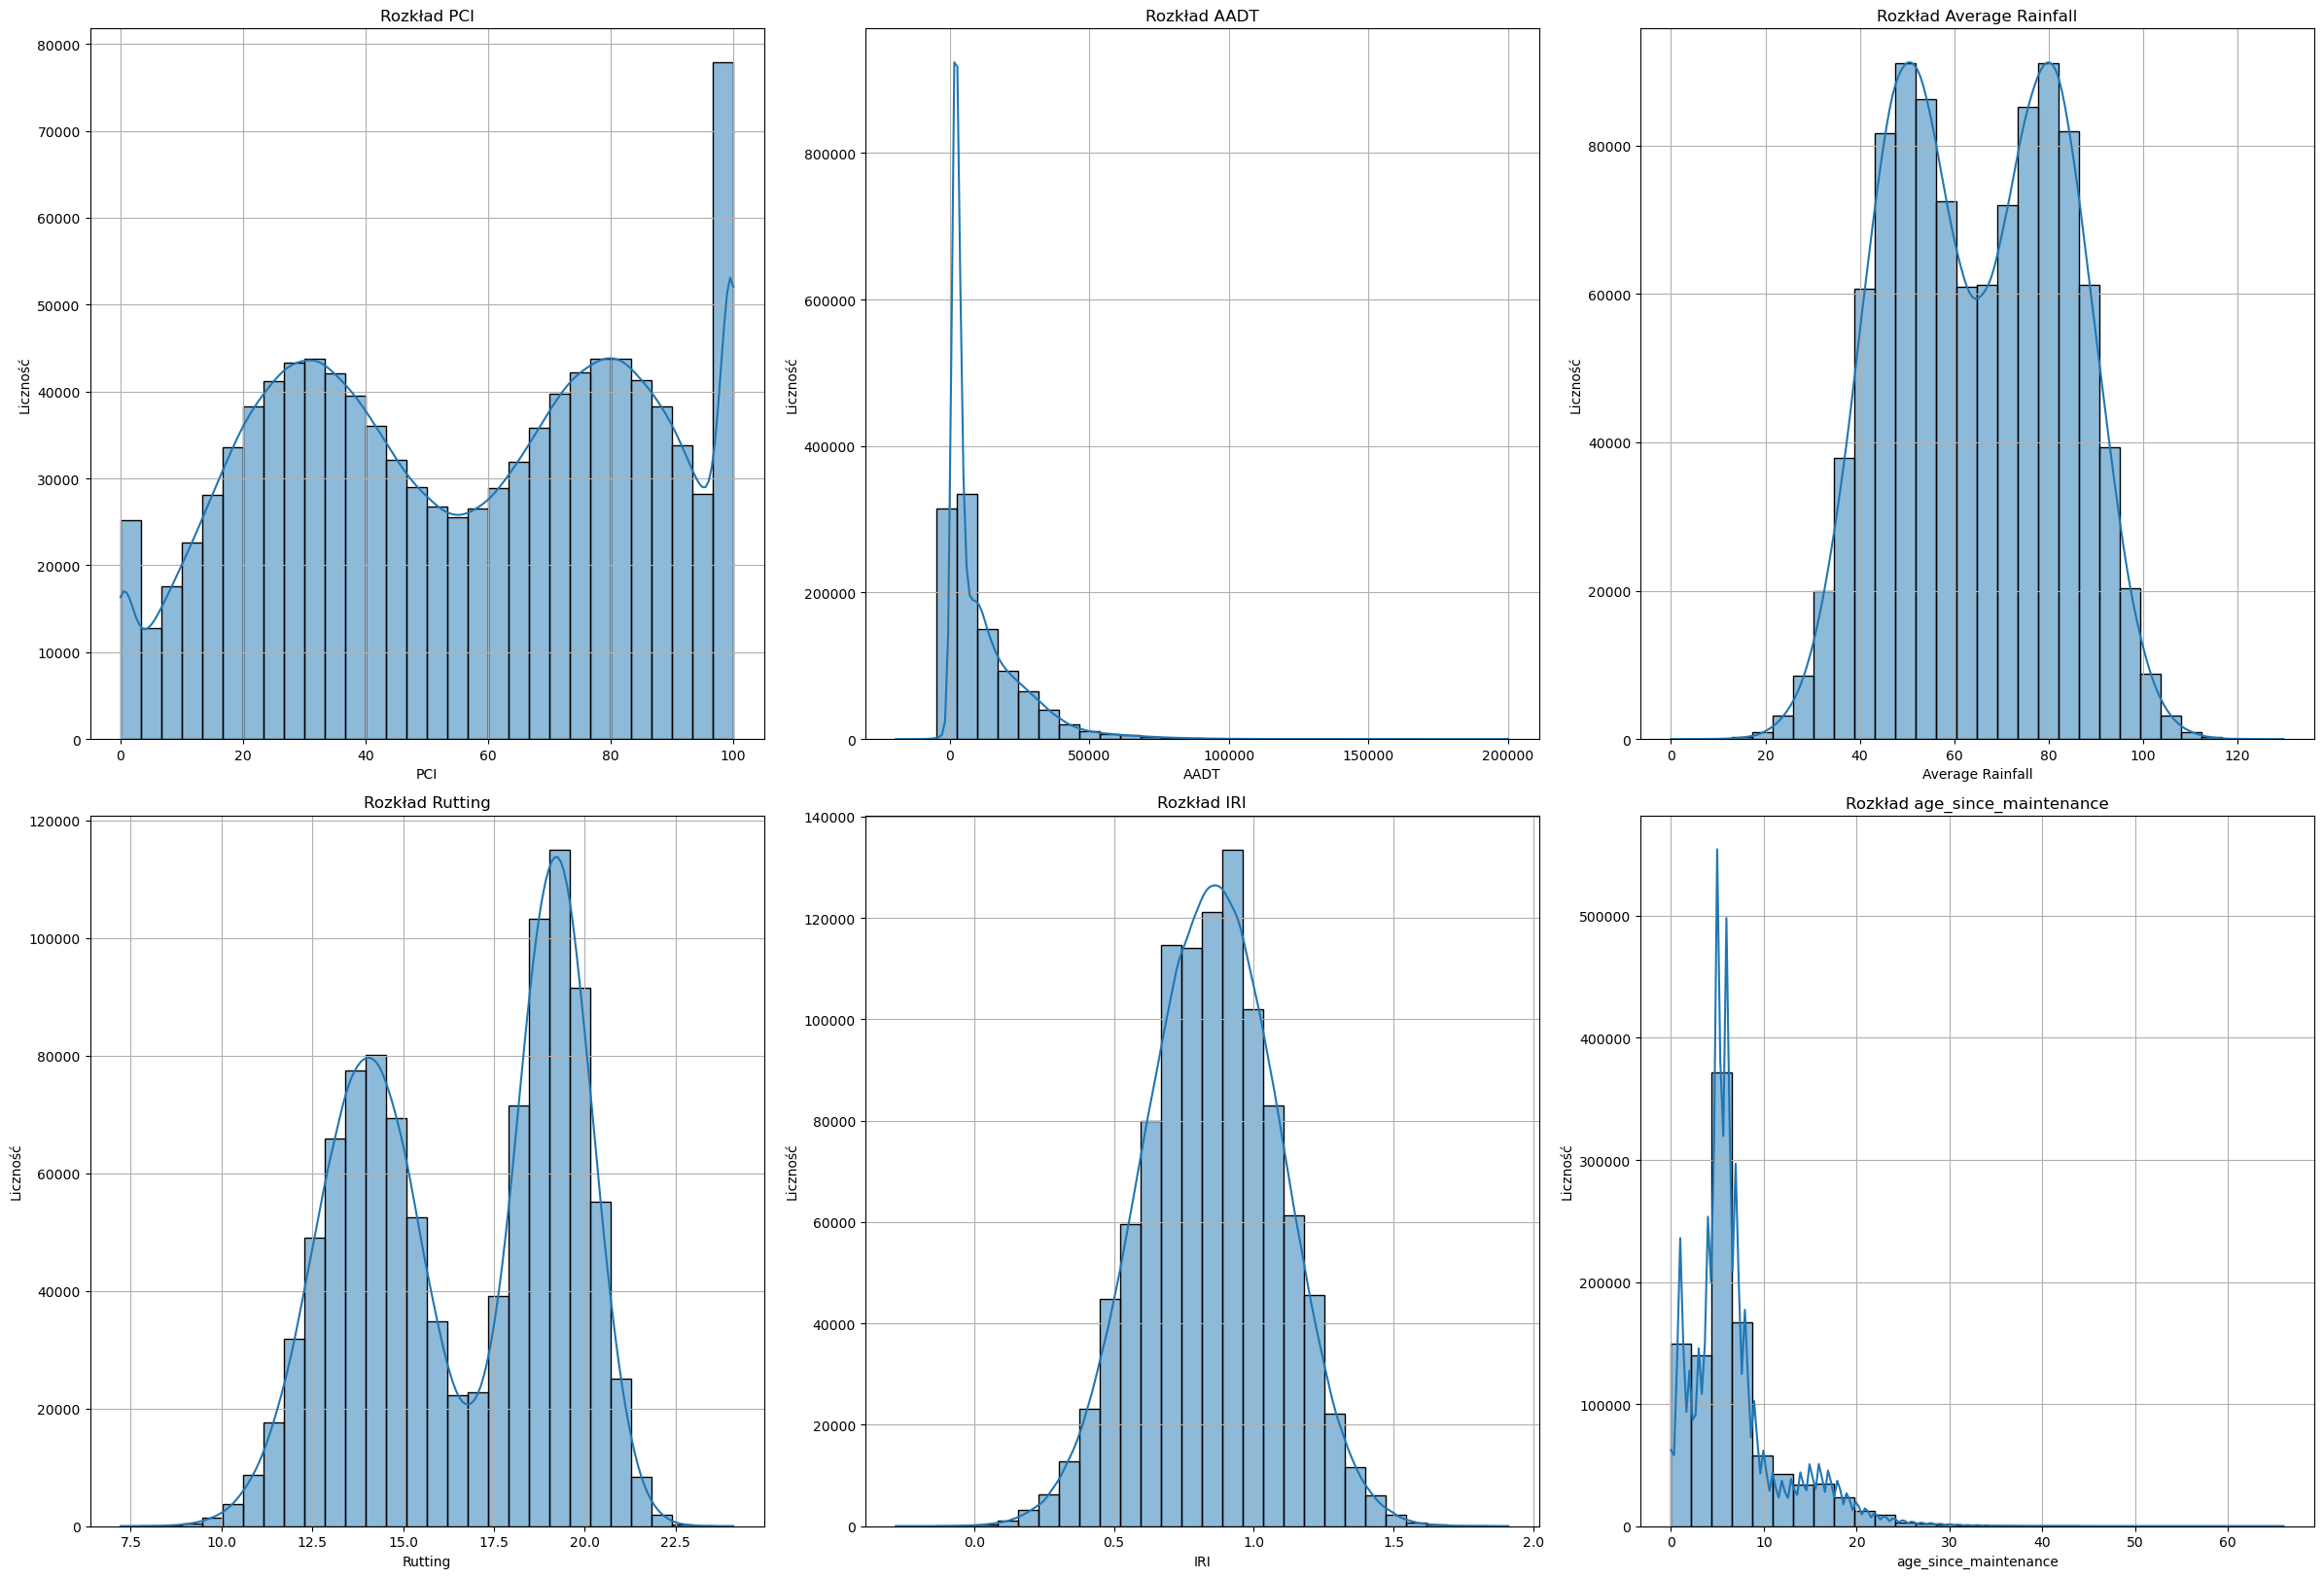

In [7]:
# Zmienne ilościowe - rozkład
numeric_cols = df.select_dtypes(include=np.number).columns.drop(['Needs Maintenance','Last Maintenance'])


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
axes = axes.flatten()  

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col].dropna(), kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Rozkład {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Liczność")
    axes[i].grid(True)


for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


categorical_cols = df.select_dtypes(include='object').columns.drop('Segment ID') 
categorical_cols = categorical_cols.insert(len(categorical_cols),'Needs Maintenance') 

fig = make_subplots(rows=3, cols=1, subplot_titles=[f'Distribution of {col}' for col in categorical_cols])


for i, col in enumerate(categorical_cols, start=1):
    value_counts = df[col].value_counts(dropna=False)
    fig.add_trace(
        go.Bar(x=value_counts.index.astype(str), y=value_counts.values, name=col),
        row=i, col=1
    )

    fig.update_xaxes(title_text=col, tickangle=45, row=i, col=1)
    fig.update_yaxes(title_text="Count", row=i, col=1)


fig.update_layout(height=1000, title_text="Categorical Feature Distributions", showlegend=False)
fig.show()


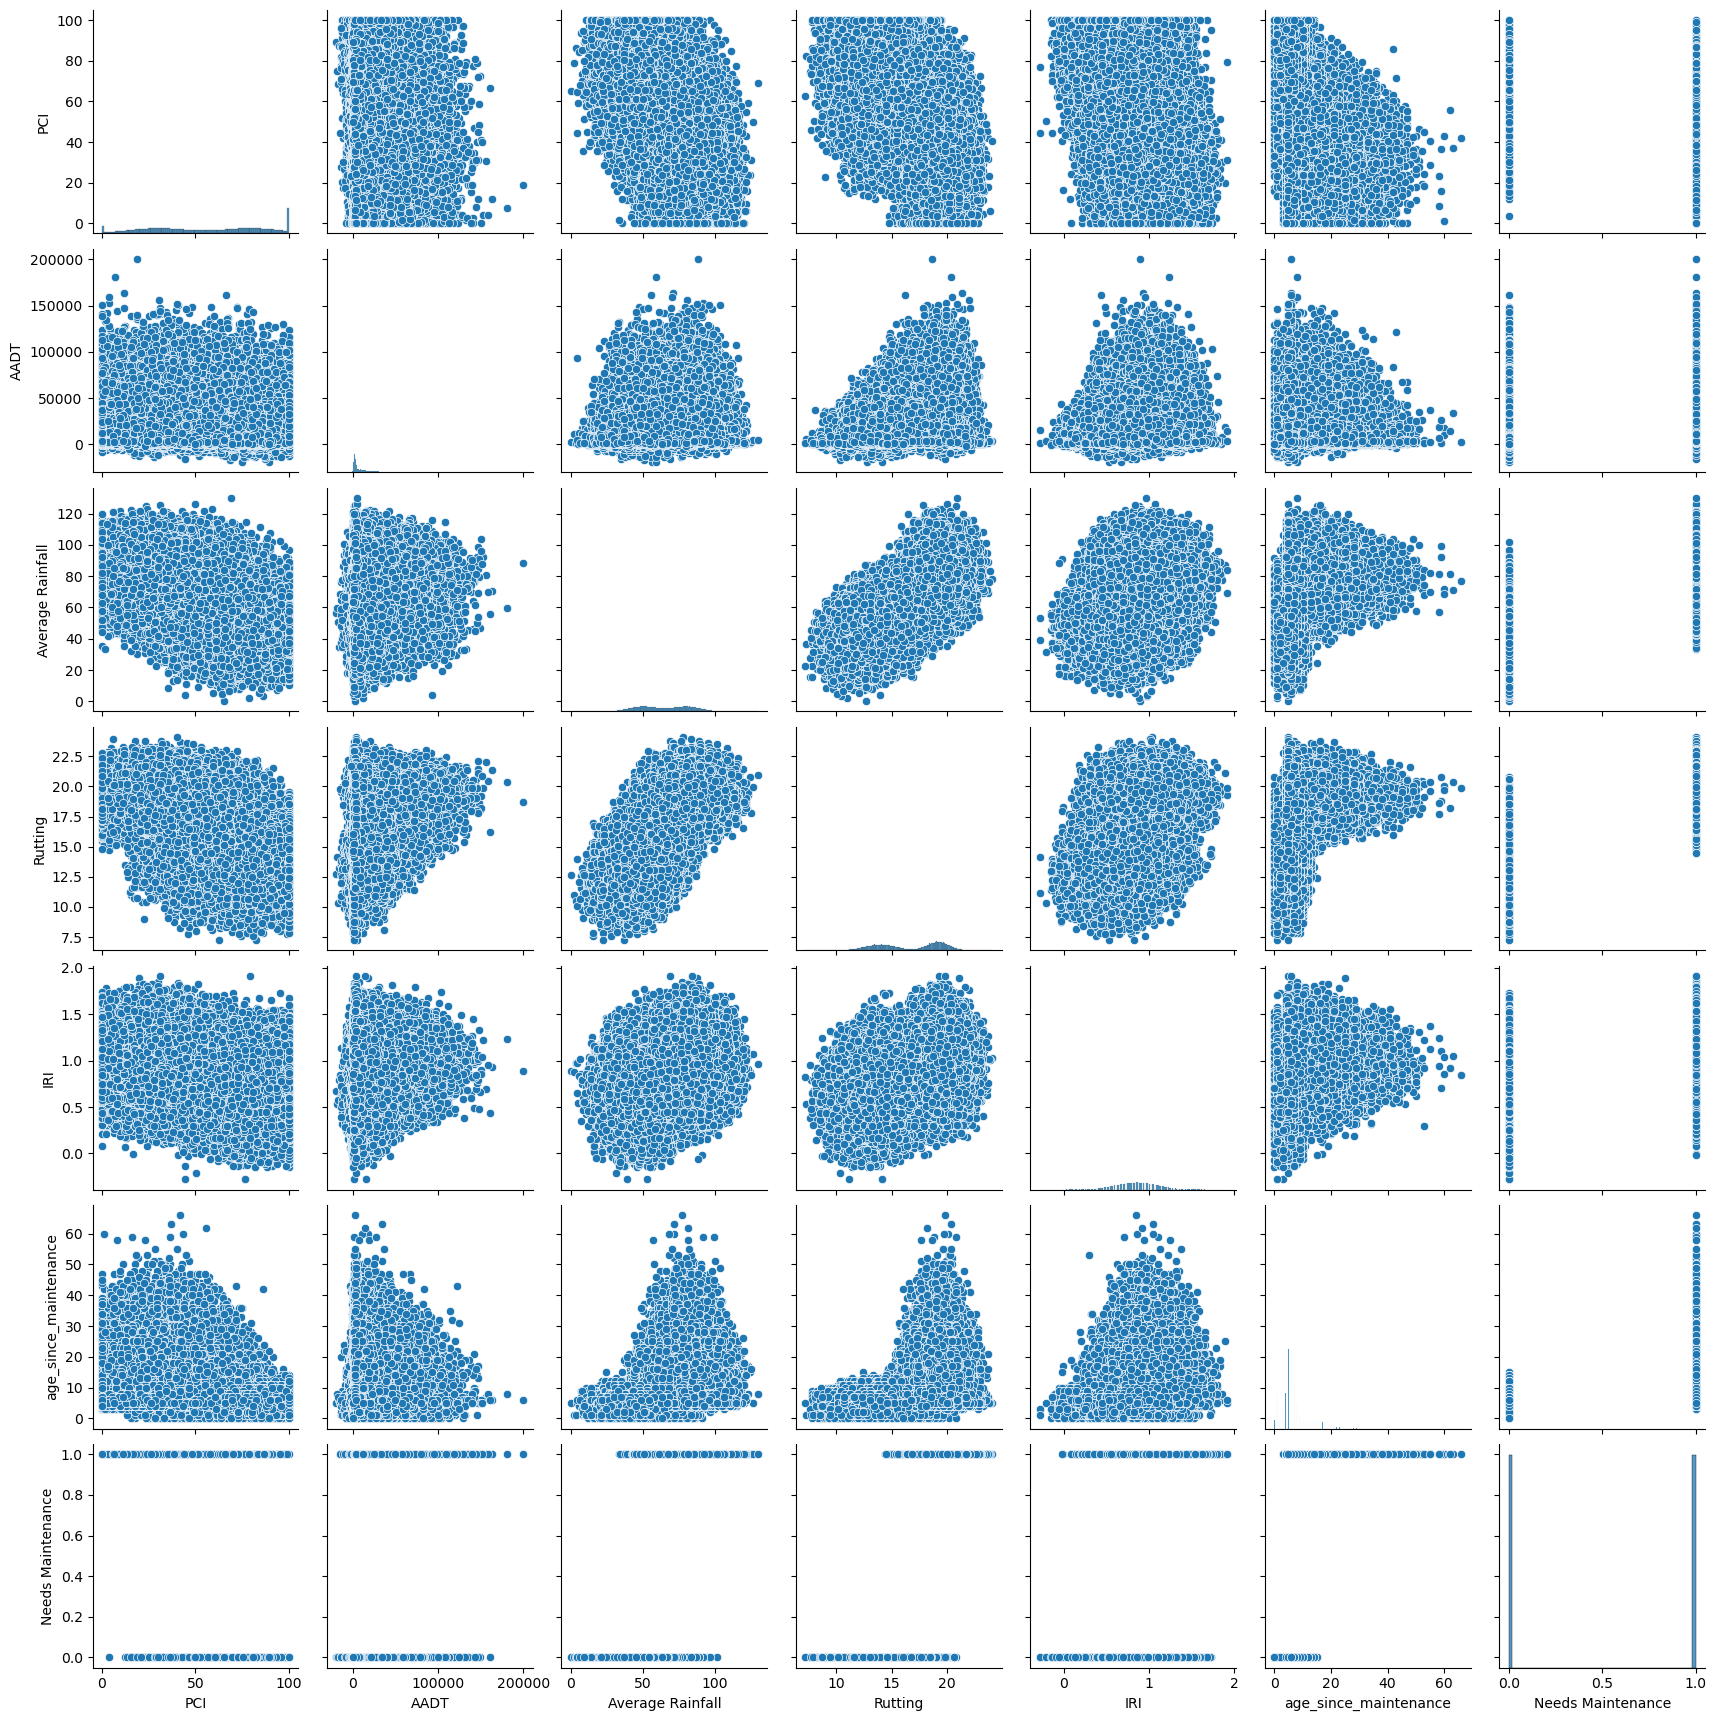

In [9]:
sns.pairplot(df[numeric_cols.insert(len(numeric_cols),'Needs Maintenance')])
plt.show()

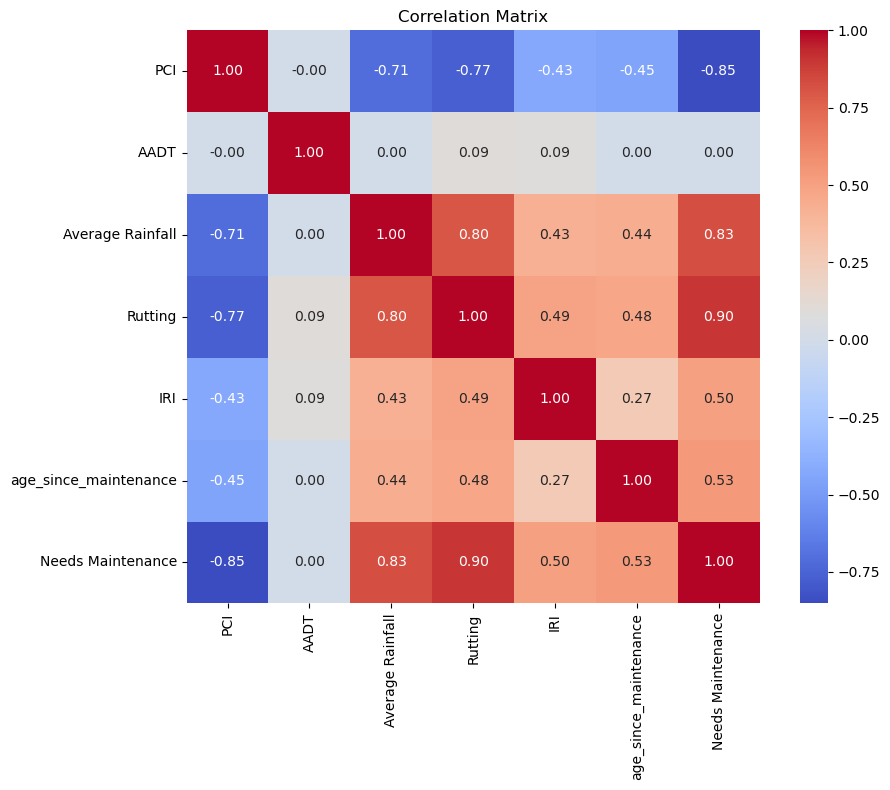

In [10]:
#Analiza Korelacji
if len(numeric_cols) > 1:
    corr = df[numeric_cols.insert(len(numeric_cols),'Needs Maintenance')].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

In [11]:
# Wybór kolumn liczbowych
num_cols = df.select_dtypes(include='number').columns.drop(['Needs Maintenance','Last Maintenance'])

# Standaryzacja zmiennych
scaler = StandardScaler()
df_stand = df.copy() 
df_stand[num_cols] = scaler.fit_transform(df_stand[num_cols])

In [12]:
df_stand_w_cats = df_stand.copy() 

road_order = [['Tertiary', 'Secondary', 'Primary']]

df_stand_w_cats['road_type_encoded'] = df_stand['Road Type'].map({'Tertiary': 0, 'Secondary': 1,'Primary' :2})

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_stand_w_cats['asphalt_type_encoded'] = le.fit_transform(df_stand['Asphalt Type'])

## Modelowanie

In [14]:
features = [
    'PCI', 'AADT', 'Average Rainfall', 'Rutting', 'IRI',
    'age_since_maintenance', 'road_type_encoded', 'asphalt_type_encoded'
]
target = 'Needs Maintenance'

X = df_stand_w_cats[features]
y = df_stand_w_cats[target]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
df_stand_w_cats['asphalt_type_encoded'].value_counts()

asphalt_type_encoded
1    525048
0    524706
Name: count, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

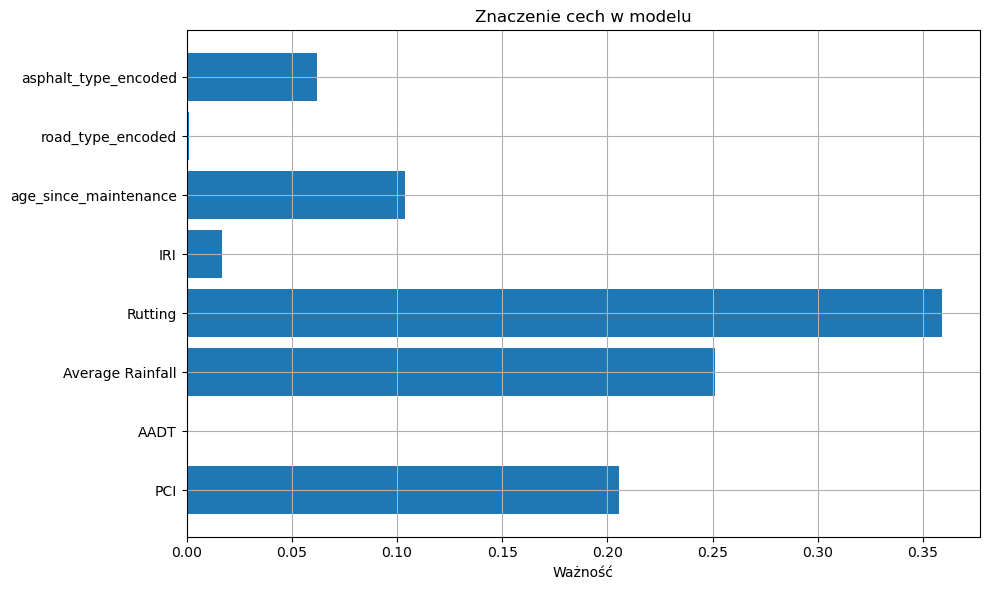

In [18]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feat_names, importances)
plt.xlabel("Ważność")
plt.title("Znaczenie cech w modelu")
plt.grid(True)
plt.tight_layout()
plt.show()


## Przewidywaine

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Dokładność (accuracy):", accuracy_score(y_test, y_pred))

[[104941      2]
 [     1 105007]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104943
           1       1.00      1.00      1.00    105008

    accuracy                           1.00    209951
   macro avg       1.00      1.00      1.00    209951
weighted avg       1.00      1.00      1.00    209951

Dokładność (accuracy): 0.999985710951603


## Dostrojenie modelu

In [20]:
from sklearn.model_selection import GridSearchCV

In [24]:
param_grid = {
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=2,  # 2-krotna walidacja krzyżowa
    scoring='accuracy',  
    n_jobs=-1, 
    verbose=2
)

# Uczenie modelu
grid_search.fit(X_train, y_train)

# Najlepsze parametry
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik accuracy:", grid_search.best_score_)

# Używamy najlepszego modelu do predykcji
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy na zbiorze testowym:", accuracy_score(y_test, y_pred))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Najlepsze parametry: {'max_depth': None, 'min_samples_split': 5}
Najlepszy wynik accuracy: 0.999982138672489
[[104940      3]
 [     2 105006]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104943
           1       1.00      1.00      1.00    105008

    accuracy                           1.00    209951
   macro avg       1.00      1.00      1.00    209951
weighted avg       1.00      1.00      1.00    209951

Accuracy na zbiorze testowym: 0.9999761849193384


## Prezentacja rozwiazan

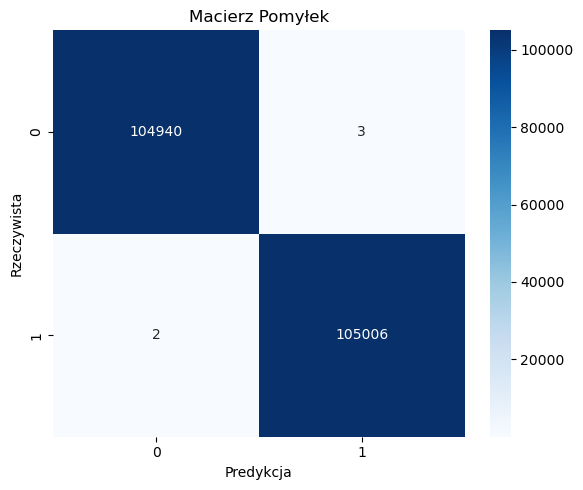

In [25]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.title('Macierz Pomyłek')
plt.tight_layout()
plt.show()